# Finding stations with most data / longest time coverage

Here you will take high-resolution observations from EMODNET and pick the stations with the longest record.
This is good if you want to know the best locations for model validation.

## Getting the list of stations from the file names
We get the list of stations from the directory `/data/sealevel/emodnet_hourly`

In [15]:
setwd("/silos/notebook_collection/obsdata_gaugedata/find_stations/")
datadir = "/data/sealevel/emodnet_hourly"
filenames = system(paste0("ls -1 ",datadir),intern=TRUE)
filenames[1:5]

[1] "EP_ERD_INT_SLEV_AL_TS_NRT_A121TG.nc"    
[2] "EP_ERD_INT_SLEV_AL_TS_NRT_A2TG.nc"      
[3] "EP_ERD_INT_SLEV_AL_TS_NRT_AalesundTG.nc"
[4] "EP_ERD_INT_SLEV_AL_TS_NRT_Aarhus.nc"    
[5] "EP_ERD_INT_SLEV_AL_TS_NRT_Aberdeen.nc"

We need to extract the station name only

In [16]:
stationnames=filenames
for (i in seq_along(stationnames)) {
    stationnames[i] = substr(stationnames[i],start=27,stop=nchar(stationnames[i])-3)
}
stationnames[1:5]

[1] "A121TG"     "A2TG"       "AalesundTG" "Aarhus"     "Aberdeen"

The next step is to go through the existing files and extract the length of the time axis and the latitude and longitude parameters. We will store this information in a data.frame.

In [129]:
library("RNetCDF") # package to load NetCDF data
gauge_stations = NULL
print(length(stationnames))
for (i in seq_along(filenames)) {
    nc = open.nc(paste0(datadir,"/",filenames[i]))
    timeaxis = var.get.nc(nc,"time")
    #timeunit = att.get.nc(nc,"time","units")
    lon = mean(var.get.nc(nc,"longitude"))
    lat = mean(var.get.nc(nc,"latitude"))
    min_time = min(timeaxis,na.rm=TRUE)
    max_time = max(timeaxis,na.rm=TRUE)
    min_year = as.numeric(format(as.POSIXct("1970-01-01")+min_time,"%Y"))
    max_year = as.numeric(format(as.POSIXct("1970-01-01")+max_time,"%Y"))
    
    #    lon = var.get.nc(nc,"lon")
    #    lat = var.get.nc(nc,"lat")
    #    name = var.get.nc(nc,"station_name")
    #    country = var.get.nc(nc,"station_country")
    mystation = data.frame(number=i, timesteps=length(timeaxis), name=stationnames[i], min_year=min_year, max_year=max_year, lon=lon, lat=lat)
    gauge_stations = rbind(gauge_stations, mystation)
    close.nc(nc)
}
gauge_stations = gauge_stations[order(gauge_stations$min_year),] # sort by first timestep
gauge_stations[1:20,] # show first lines

[1] 345


,number,timesteps,name,min_year,max_year,lon,lat
182,182,1173509,Kungsholmsfort,1901,2021,15.5894,56.1053
248,248,1135665,Ratan,1901,2021,20.8950,63.9861
289,289,1160374,Stockholm,1901,2021,18.0817,59.3242
281,281,969861,Smogen,1910,2021,11.2178,58.3536
72,72,920860,Furuogrund,1916,2021,21.2306,64.9158
165,165,779952,Klagshamn,1929,2021,12.8936,55.5222
229,229,531857,Oskarshamn,1960,2021,16.4781,57.2750
321,321,531904,Visby,1960,2021,18.2844,57.6392
224,224,494694,OlandsNorraUdde,1961,2021,17.0972,57.3661
288,288,488333,Stenungsund,1962,2021,11.8325,58.0933


Next step is to select the North Sea and Baltic Sea only.

In [130]:
lonrange=c(-5,31)
latrange=c(50,67)
gauge_stations = gauge_stations[gauge_stations$lat > latrange[1],]
gauge_stations = gauge_stations[gauge_stations$lat < latrange[2],]
gauge_stations = gauge_stations[gauge_stations$lon > lonrange[1],]
gauge_stations = gauge_stations[gauge_stations$lon < lonrange[2],]
head(gauge_stations)

,number,timesteps,name,min_year,max_year,lon,lat
182,182,1173509,Kungsholmsfort,1901,2021,15.5894,56.1053
248,248,1135665,Ratan,1901,2021,20.8950,63.9861
289,289,1160374,Stockholm,1901,2021,18.0817,59.3242
281,281,969861,Smogen,1910,2021,11.2178,58.3536
72,72,920860,Furuogrund,1916,2021,21.2306,64.9158
165,165,779952,Klagshamn,1929,2021,12.8936,55.5222


In [140]:
measurements_in_box = gauge_stations
measurements_in_box$rank = -1

In [141]:
myrank = 1
measurements_in_box$rank[(measurements_in_box$min_year < 1950) & (measurements_in_box$rank==-1)]=myrank
print(paste0("rank ",myrank,": ",sum(measurements_in_box$rank==myrank)," stations"))
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] == myrank) {
        for (j in seq_len(nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] == -1) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        measurements_in_box$rank[j]=0
                    }
                }
            }
        }
    }
}
print(measurements_in_box[measurements_in_box$name=="Stockholm",])

[1] "rank 1: 6 stations"
    number timesteps      name min_year max_year     lon     lat rank
289    289   1160374 Stockholm     1901     2021 18.0817 59.3242    1


In [142]:
myrank = 2
measurements_in_box$rank[(measurements_in_box$min_year < 1970) & (measurements_in_box$rank==-1)]=myrank
print(paste0("rank ",myrank,": ",sum(measurements_in_box$rank==myrank)," stations"))
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] == myrank) {
        for (j in seq_len(nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] == -1) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        measurements_in_box$rank[j]=0
                    }
                }
            }
        }
    }
}

[1] "rank 2: 8 stations"


In [143]:
myrank = 3
measurements_in_box$rank[(measurements_in_box$min_year < 1990) & (measurements_in_box$rank==-1)]=myrank
print(paste0("rank ",myrank,": ",sum(measurements_in_box$rank==myrank)," stations"))
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] == myrank) {
        for (j in seq_len(nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] == -1) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        measurements_in_box$rank[j]=0
                    }
                }
            }
        }
    }
}

[1] "rank 3: 19 stations"


In [144]:
myrank = 4
measurements_in_box$rank[(measurements_in_box$min_year < 2000) & (measurements_in_box$rank==-1)]=myrank
print(paste0("rank ",myrank,": ",sum(measurements_in_box$rank==myrank)," stations"))
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] == myrank) {
        for (j in seq_len(nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] == -1) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        measurements_in_box$rank[j]=0
                    }
                }
            }
        }
    }
}

[1] "rank 4: 40 stations"


In [145]:
myrank = 5
measurements_in_box$rank[(measurements_in_box$min_year < 2010) & (measurements_in_box$rank==-1)]=myrank
print(paste0("rank ",myrank,": ",sum(measurements_in_box$rank==myrank)," stations"))
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] == myrank) {
        for (j in seq_len(nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] == -1) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        measurements_in_box$rank[j]=0
                    }
                }
            }
        }
    }
}

[1] "rank 5: 34 stations"


In [146]:
myrank = 6
measurements_in_box$rank[(measurements_in_box$min_year < 2015) & (measurements_in_box$rank==-1)]=myrank
print(paste0("rank ",myrank,": ",sum(measurements_in_box$rank==myrank)," stations"))
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] == myrank) {
        for (j in seq_len(nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] == -1) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        measurements_in_box$rank[j]=0
                    }
                }
            }
        }
    }
}

[1] "rank 6: 90 stations"


In [147]:
stations_to_keep = c("CuxhavenTG")
for (i in seq_len(nrow(measurements_in_box))) {
    if (measurements_in_box$rank[i] > 0) {
        for (j in seq(from=i+1,to=nrow(measurements_in_box))) {
            if (measurements_in_box$rank[j] > 0) {
                if (abs(measurements_in_box$lat[i]-measurements_in_box$lat[j]) < 0.3) {
                    if (abs(measurements_in_box$lon[i]-measurements_in_box$lon[j]) < 0.6) {
                        if (measurements_in_box$timesteps[i] > measurements_in_box$timesteps[j]) {
                            if ((measurements_in_box$name[j] %in% stations_to_keep)==FALSE) {
                                measurements_in_box$rank[j] = -1
                            }
                        } else {
                            if ((measurements_in_box$name[i] %in% stations_to_keep)==FALSE) {
                                measurements_in_box$rank[i] = -1
                            }
                        }
                    }
                }
            }
        }
    }
}
print(paste0("remaining: ",sum(measurements_in_box$rank>0)," stations"))

[1] "remaining: 138 stations"


Let us plot where these boxes are.

Warning message:
"Removed 26579 rows containing missing values (geom_path)."Warning message:
"Removed 9347 rows containing missing values (geom_path)."Warning message:
"Removed 26579 rows containing missing values (geom_path)."Warning message:
"Removed 9347 rows containing missing values (geom_path)."

png 
  2

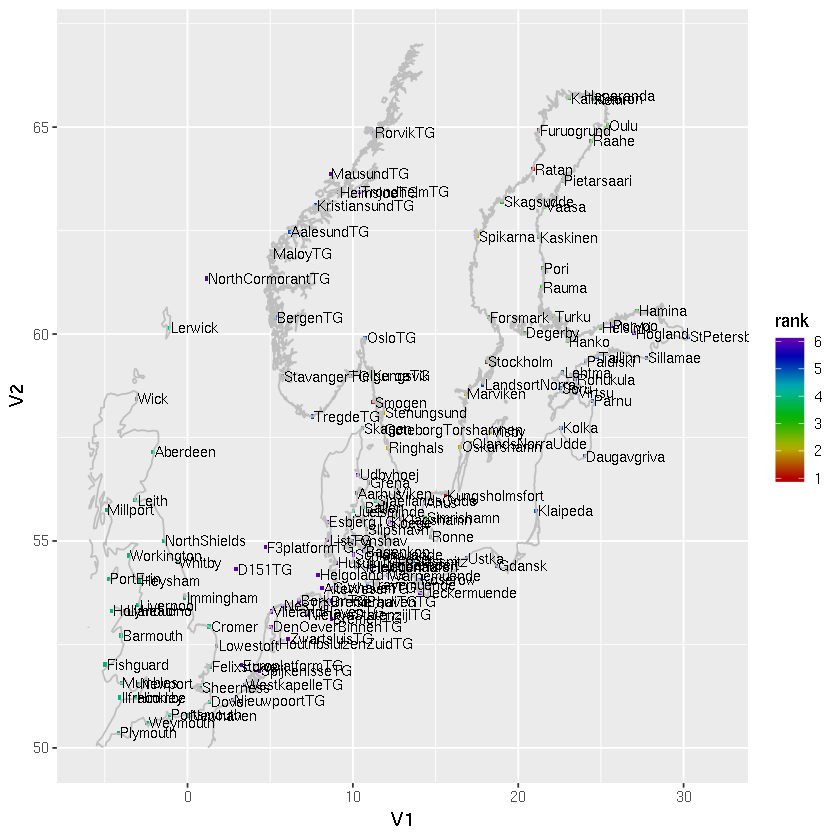

In [152]:
boxes_to_plot = measurements_in_box[measurements_in_box$rank>0,]
boxes_to_plot$xmin = boxes_to_plot$lon-0.1
boxes_to_plot$xmax = boxes_to_plot$lon+0.1
boxes_to_plot$ymin = boxes_to_plot$lat-0.05
boxes_to_plot$ymax = boxes_to_plot$lat+0.05
coastline=read.csv("coastline_world.txt",sep="",header=FALSE)
coastline_baltic=read.csv("coastline_baltic.txt",sep="",header=FALSE)
library(ggplot2)
myplot = ggplot()+
  geom_rect(data=boxes_to_plot,mapping=aes(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax,fill=rank))+
  scale_fill_gradientn(colors=rainbow(100,end = 0.75,v=0.7))+
  geom_path(data=coastline[coastline$V1<0,],mapping=aes(x=V1,y=V2),color="gray")+
  geom_path(data=coastline_baltic,mapping=aes(x=V1,y=V2),color="gray")+
  geom_text(data=boxes_to_plot,mapping=aes(x=xmax,y=lat,label=name),hjust="left",size=3)+
  scale_x_continuous(limits = c(-6,32))+
  scale_y_continuous(limits = latrange)
  
print(myplot)
png("gauge_stations.png",width=1600,height=1080,units="px",res=96)
print(myplot)
dev.off()

We save the station list to a csv file

In [162]:
write.table(boxes_to_plot[,c("name","lat","lon","rank","min_year","max_year","timesteps")],"gauge_stations.csv",col.names=TRUE,row.names=FALSE,sep=";",quote=FALSE)